## Problem Overview

**Unlabeled data**
- Exists large repositories of unlabeled free text such as customer reviews, call center transcripts, scientific article abstracts, social media comments, tweets etc. 
- Most text-based models are supervised, hence, such textual data mostly unused

**Manual labeling**
- Resort to manual labeling of a small subset (~10%) of data for supervised learning
- Manual labeling is: 
    - **Tedious** 
        - Nobody really wants to do it and even if someone is forced to do it, labeling quality generally deteriorates over time
        - Some documents requires labeling by domain experts, who will usually not have the luxury of time to label the documents one by one
        - *Context drift*: new labels would emerge over time as the business evovles, not sustainable to repeat manual labeling everytime
    - **Highly subjective**
        - Different reviewers can label the same text differently especially for multi-label datasets (one piece of text can belong to multiple categories)
        - The same reviewer can even label the same text differently at different times
        - Manually labeled dataset are **highly inconsistent** and there are reservations about using these inconsistent manual labels as ground truth

**Short Text**
- Documments with a small number of words (<100 words after text preprocessing) are common
- Unsupervised methods such as topic modeling does not perform well in the case of short text due to highly sparse document-term matrix




### Project Objective

- Develop a **semi-supervised method for automatic labeling of short text**
- Proof of concept using a kaggle dataset with 45000 movies from the Full MovieLens Dataset (https://www.kaggle.com/rounakbanik/the-movies-dataset/home)
- Automatically label movie genres using plot synopsis
- Simplified multi-label dataset of **~21500 movies across 6 genres** used in this notebook (https://drive.google.com/file/d/1U_Y3z1mecNtuiabUHA_TpryExVNtSbmH/view?usp=sharing)
- Peformance comparison to supervised learning using 10% labeled data in terms of **macro F1 score** (equal weightage across all genres)

In [8]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from helper.preprocess import Preprocess, replace_bigrams
from helper.enrich import Enrich
from helper.label import Label
from helper.supervised import Supervised

### Exploratory Data Analysis

In [2]:
movies = pd.read_csv('movies21500.csv')
movies.head()

,overview,Action,Romance,Science Fiction,Thriller,War,Western
0,A family wedding reignites the ancient feud be...,0,1,0,0,0,0
1,"Cheated on, mistreated and stepped on, the wom...",0,1,0,0,0,0
2,"Obsessive master thief, Neil McCauley leads a ...",1,0,0,1,0,0
3,An ugly duckling having undergone a remarkable...,0,1,0,0,0,0
4,"A mischievous young boy, Tom Sawyer, witnesses...",1,0,0,0,0,0


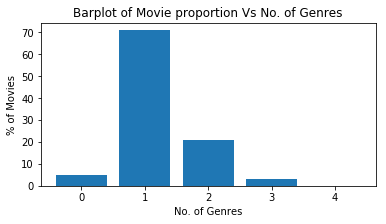

In [3]:
movies_genre = movies.iloc[:,1:]
labelcount = []

for i in range(5):
    labelcount.append(round((movies_genre.sum(axis=1)==i).mean(),3)*100)

f, ax = plt.subplots(figsize=(6, 3))
plt.bar(list(range(5)), labelcount)
ax.set_title('Barplot of Movie proportion Vs No. of Genres')
x_axis = plt.xlabel('No. of Genres')
y_axis = plt.ylabel('% of Movies')
plt.show() 

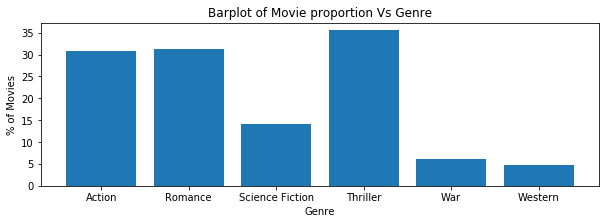

In [4]:
moviecount = (round(movies_genre.mean(axis=0),3)*100).tolist()

f, ax = plt.subplots(figsize=(10, 3))
plt.bar(movies_genre.columns, moviecount)
ax.set_title('Barplot of Movie proportion Vs Genre')
x_axis = plt.xlabel('Genre')
y_axis = plt.ylabel('% of Movies')
plt.show() 

In [5]:
print ('Cardinality: ', round(movies_genre.sum(axis=1).mean(),3))
print ('Label Density: ', round(movies_genre.sum(axis=1).mean()/len(movies_genre.columns),3))
print ('MeanIR: ', round(np.mean(np.max(moviecount)/moviecount),3)) # Mean imbalance ratio

Cardinality:  1.225
Label Density:  0.204
MeanIR:  3.171


### Text Preprocessing

- expand contractions: Expand words containing a '. e.g. it's to it is
- filter out PERSON named entity: Use named entity recognition to remove character names from synopsis
- lemmatize text: Reduce words to root words, for e.g. jumps, jumped, jumping are all reduced to jump
- replace negation: look for keyword 'not' and replace the next word with its antonym. e.g. not happy to sad
- remove special characters: remove special characters like punctuations
- remove digits: remove digits 
- remove stopwords: remove stopwords (common words in english language eg. he, she, is) from nltk stopword list and also a custom stopword list
- keep pos: Remove adverbs which are not likely to be useful in topic modeling

In [6]:
corpus = movies['overview']

normalized_corpus = []
for text in corpus:
    preprocess = Preprocess(text)

    preprocess.expand_contractions()        
    preprocess.filter_out_PERSON_named_entity()
    preprocess.lemmatize_text()           
    preprocess.replace_negation()

    preprocess.remove_special_characters()
    preprocess.remove_digits()
    preprocess.remove_stopwords()

    preprocess.keep_pos(keep_list =['n','v','a'])

    normalized_corpus.append(preprocess.return_text())
    
movies['overview'] = normalized_corpus

### Replace Bigrams

- Join bigrams that appear frequently into one word, e.g. romantic comedy to romantic_comedy
- Similar to how gensim usually deals with bigrams

In [9]:
# Replace bigrams

corpus = movies['overview']

min_df = 50
max_df = 500

vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df =min_df, max_df = max_df)
vectorizer.fit(corpus)

bigrams = [word for word in vectorizer.get_feature_names() if len(word.split(' '))==2]

corpus_replaced = [replace_bigrams(text,bigrams) for text in corpus]
movies['overview'] = corpus_replaced

In [10]:
# Clean up corpus (drop rows with na and reset index)

print(movies.shape)
movies = movies.dropna()
movies = movies.reset_index(drop=True)
print(movies.shape)

(21330, 7)
(21330, 7)


### Topic Modeling - Non-negative matrix Factorization

- Generate initial dictionary of keywords from text corpus using NMF topic modeling
- Test a range of topic numbers and use **coherence score** (gensim) to select the best number of topics
- Mix and match top 20 keywords from each topics to create initial dictionary (*Human component in semi-supervised method*)
- All further modeling steps leading to final labeling of the documents will be dependent on this dictionary
- Domain experts just need to agree on this dictionary for a **consistent source of ground truth**

In [11]:
from topic_model import Topic_model

topic_model = Topic_model()

#Get document-term matrix for topic modeling
corpus = movies['overview']
min_df = 3
max_df = 300

dtm = topic_model.get_dtm(corpus, min_df, max_df)

#range of topic numbers to test
topic_num = [7,8,9,10,11,12,13,14,15,16,17,18]

#get list of coherence scores of topic numbers
score_list = topic_model.get_nmf_coherence_score(dtm, topic_num)

#print score list
for i in range(len(topic_num)):
    print (topic_num[i],'Topics: ',np.round(score_list[i],3))

7 Topics:  0.335
8 Topics:  0.345
9 Topics:  0.362
10 Topics:  0.348
11 Topics:  0.347
12 Topics:  0.356
13 Topics:  0.365
14 Topics:  0.366
15 Topics:  0.368
16 Topics:  0.364
17 Topics:  0.375
18 Topics:  0.352


In [12]:
# Show topic keywords for best number of topics and save dataframe as prelim_keywords.csv
topic_model.show_topics(dtm = dtm, best_n = 17, n_words = 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,paris,date,wedding,apartment,married,best_friend,party,romantic,perfect,sex,friendship,london,successful,baby,ask,share,year_old,feeling,divorce,feel
1,terrorist,hostage,bomb,president,nuclear,international,london,prevent,special,security,unit,cia,united,release,commando,cell,elite,computer,hijack,major
2,band,gold,outlaw,western,sheriff,stranger,west,mexican,desert,bandit,ranch,gun,texas,mexico,civil_war,wild,small_town,cattle,border,cowboy
3,ii,japanese,camp,nazi,prisoner,jewish,france,wwii,resistance,japan,allied,pilot,true_story,concentration,line,unit,pow,germany,troop,invasion
4,king,princess,prince,warrior,defeat,kingdom,quest,throne,queen,hero,court,rule,ancient,general,god,monster,classic,royal,epic,legendary
5,ship,space,captain,pirate,passenger,board,crash,sea,station,creature,submarine,pilot,survivor,astronaut,cargo,aboard,moon,nuclear,plane,spaceship
6,truth,memory,haunt,accident,experiment,mystery,wake,hospital,ghost,reality,witness,spirit,commit,trap,patient,five,person,nightmare,mind,suicide
7,high_school,teacher,kid,class,teenage,crush,senior,teenager,teen,friendship,popular,summer,classmate,best_friend,separate,teach,graduation,develop,graduate,gym
8,indian,cavalry,tribe,india,reservation,chief,fort,white,territory,peace,raise,west,wagon,defend,bandit,pakistani,president,america,term,settler
9,comedy,book,drama,role,direct,feature,writer,documentary,actor,thriller,novel,classic,famous,comic,musical,film_direct,release,music,produce,artist


### Dictionary Enrichment

**Seeded Topic Modeling**
- Seeded LDA  first reported in Jagarlamudi J. et. al. Incorporating Lexical Priors into Topic Models, 2012 may not be suitable for topic modeling of short texts
- Develop seeded topic modeling method for NMF topic modeling based on normalized pointwise mutual information (npmi)
    - Pointwise mutual information measures how often 2 words co-occured together in the same document
    - Words that frequently co-occured together tend to be semantically related and should be in the same topic
- List of keywords from initial dictionary as seed words for each topic
- *Virtual document*: synthetic document formed by joining each seed word with highly co-occured words based on npmi scores
- Use virtual documents to restrict the npmi matrix to only words that highly co-occured with the list of seed words
- Dimension reduction of restricted npmi matrix from len(vocabulary) to 300
- NMF modeling on the restricted npmi matrix (with customized initialization of W and H matrices) encourages words to converge around the seed topics

**Dictionary Enrichment**
- Add new words discovered in this way (top 20 words for each topic) to the initial dictionary
- Prune dictionary (if required) by removing words that highly co-occured with words in other topics

In [13]:
dictionary = pd.read_csv('dict.csv')
genre = dictionary.columns

enrich = Enrich(dictionary,genre)

corpus = movies['overview']
min_df = 3
max_df = 300

# Get document-term matrix for corpus
dtm = enrich.get_dtm(corpus, min_df, max_df)

# Keyword matching baseline using dictionary
base_yres_test =  enrich.get_baseline_score(movies, cutoff = 1)
base_yres_test

,Action,Romance,Science Fiction,Thriller,War,Western
Precision,0.5929,0.5866,0.6538,0.6163,0.3668,0.3333
Recall,0.2589,0.2241,0.3617,0.2640,0.4723,0.7198
F1-score,0.3604,0.3243,0.4658,0.3697,0.4129,0.4557


In [14]:
# Get full word co-occurence matrix based on gensim npmi scorer
npmi_full = enrich.get_full_cooccurence_matrix()

# Generation of virtual documents
vdoc = enrich.generate_virtual_doc(npmi_full, percentile = 70)

# Get npmi vectors (dimension = 300) for each word on the restricted npmi matrix
npmi_embed, vdoc_vocab = enrich.get_restricted_npmi_vectors(vdoc, npmi_full, size = 300)

# NMF on restricted npmi matrix using customize W and H matrices
nmf = enrich.customized_nmf(npmi_embed, vdoc_vocab)

# Potential new words to be added to dictionary
new_words_df = enrich.new_words(nmf, vdoc_vocab, n_words = 20)
new_words_df

,Action,Romance,Science Fiction,Thriller,War,Western
0,fu,crush,population,mafia,command,horse
1,kung,teacher,creature,undercover,raid,mexican
2,china,attend,crash,cia,germany,posse
3,martial,music,orbit,operative,occupied,rancher
4,ching,dance,spacecraft,hitman,partisan,territory
5,swordsman,senior,mutate,mob,lt,frontier
6,sword,torrid,animal,corrupt,refugee,herd
7,dynasty,None,transform,fbi,gestapo,confederate
8,karate,None,lab,assassin,reich,None
9,monk,None,infect,international,navy,None


In [15]:
# Remove dictionary words that highly co-occured in other topics
#set cutoff as 1 if pruning not required 

dict2_sel, dict2_list_idx, enriched_dict = enrich.pruning(npmi_full, vdoc_vocab, cutoff = 1)
enriched_dict

,Action,Romance,Science Fiction,Thriller,War,Western
0,mob,romantic,giant,police_detective,camp,posse
1,mafia,sexual,animal,mafia,nazi,confederate
2,monk,wedding,mutate,loose,resistance,west
3,assassin,dance,virus,investigation,ww,cattle
4,kgb,summer,spaceship,mob,vietnam,indian
5,terrorist,torrid,science,assassin,navy,western
6,judo,teenage,transform,justice,prisoner,cavalry
7,karate,crush,orbit,terrorist,commander,ranch
8,hero,married,unknown,inspector,history,gold
9,ching,music,robot,witness,jewish,texas


### Automatic Document Labeling

- Re-generate restricted npmi matrix based on new seed words from enriched dictionary
- Dimension reduction of restricted npmi matrix from len(vocabulary) to 1024 (to take into account higher variability of document vectors)
- Compute document-level vectors by simple averaging of word vectors 
    - Tried more involved combination of word vectors into document vectors but they did not work better
    - Arora S. et. al. A Simple but Tough-to-Beat Baseline for Sentence Embeddings, 2017
    - Rücklé A. et. al. Concatenated Power Mean Word Embeddings as Universal Cross-Lingual Sentence Representations, 2018
- Use top 10 documents with most number of seed words as seed documents to initialize custom matrices for NMF
- Annotate top documents (topic score of + 0.5 * standard deviation from mean) of each topic as 1 and bottom documents (topic score of -0.5 * standard deviation from mean) as 0
- Create a balanced train set using these 'labeled' documents and classify remaining unannotated documents (higher uncertainty) using a naive bayes model

In [16]:
# Initialize label class
label = Label(dict2_sel, genre)

corpus = movies['overview']
min_df = 3
max_df = 300

# Get document-term matrix for corpus
dtm = label.get_dtm(corpus, min_df, max_df)

# Generation of virtual doc
vdoc = label.generate_virtual_doc(npmi_full, percentile = 50)

# New restricted npmi matrix
npmi_embed, vdoc_vocab = label.get_restricted_npmi_vectors(vdoc, npmi_full, size = 1024)

#Compute doc embedding from npmi word embedding (simple averaged word embedding)
doc_npmi_embed = label.compute_doc_vectors(npmi_embed, vdoc_vocab)

# Seeded document for each topic (used as seeds to initialize custom matrices in NMF)
doc_seed_idx = label.seed_doc(dict2_list_idx, top = 10)

# NMF topic modeling based on seeded documents
nmf = label.customized_nmf(doc_npmi_embed, doc_seed_idx)

# "label" documents with very high and very low topic score and classify remaining unlabeled documents (higher uncertainty) using a naive bayes model
mnb = MultinomialNB()
ypred = label.auto_label_classifier(nmf, movies, mnb, m = 0.5, min_df = 3, max_df = 300)

/data/home/t0917000/notebooks/raw_data/nlp/6class/label.py:74: RuntimeWarning: invalid value encountered in true_divide
  doc_npmi_embed = np.array(np.divide(doc_npmi_embed,self.tf_dtm.sum(axis=1).reshape(-1,1)))


### Comparison with Supervised Learning

- The same 20% of the data was used as test data for comparison between the semi-supervised method used in this notebook and supervised learning
- MLP neural network model, graident boosted trees and random forest model was trained on 10% of the data (one Vs rest classfier for multi-label) to predict the labels of the test data 

In [17]:
indices = np.array(range(movies.shape[0]))

# 20% hold-out for test data
train_idx0, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

ypred_test = ypred.iloc[test_idx,:]

ytrue = movies.iloc[:,1:]
ytrue_test = ytrue.iloc[test_idx,:]

auto_yres_test = pd.DataFrame(np.zeros((3,len(genre))), index = ['Precision','Recall', 'F1-score'],columns = genre)
for i in range(len(genre)):

    auto_yres_test.iloc[0,i] = round(precision_score(ytrue_test.iloc[:,i], ypred_test.iloc[:,i]),4) 
    auto_yres_test.iloc[1,i] = round(recall_score(ytrue_test.iloc[:,i], ypred_test.iloc[:,i]),4)
    auto_yres_test.iloc[2,i] = round(f1_score(ytrue_test.iloc[:,i], ypred_test.iloc[:,i]),4)

auto_yres_test

,Action,Romance,Science Fiction,Thriller,War,Western
Precision,0.3929,0.5554,0.4673,0.6647,0.3499,0.3333
Recall,0.5711,0.3541,0.6072,0.2997,0.6494,0.8019
F1-score,0.4655,0.4325,0.5281,0.4131,0.4548,0.4709


In [18]:
# Supervised Learning document-term matrix using 10% train data for supervised learning
supervised = Supervised(test_idx, genre)
supervised.get_dtm(movies, train_idx0, min_df = 3, max_df = 300)

#Multilayer perceptron classifier
mlp = MLPClassifier(hidden_layer_sizes=(512,64,),random_state=42)
mlp_yres_test = supervised.classifier(mlp)

#Gradient boosted trees
gbm = GradientBoostingClassifier(random_state = 42)
gbm_yres_test = supervised.classifier(gbm)

#Random Forest
rf = RandomForestClassifier(n_estimators = 500,random_state = 42,n_jobs=-1)
rf_yres_test = supervised.classifier(rf)

### Conclusion

- Semi-supervised automatic labeling method developed achieved marco F1-score of ~47% which is close to the performance of the supervised MLP model and outperformed the supervised gradient boosted tree and random forest without using any individual manual labeling of documents
- Automatic labeled documents were consistently labeled using the dictionary crafted and avoided inconsistencies issue that are likely to arise from labeling documents one by one
- Interpretable model as the keywords involved in the labeling process were clearly 
- Future Work:
    1. Testing on more datasets to fine-tune method to be more stable and generalizable
    2. Better way of combining word vectors into document vectors
    3. Better classifier (instead of naive bayes) to classify remaining unannotated documents 

In [19]:
summary = pd.concat([np.round(base_yres_test.mean(axis=1),3),np.round(auto_yres_test.mean(axis=1),3),np.round(mlp_yres_test.mean(axis=1),3),np.round(gbm_yres_test.mean(axis=1),3),np.round(rf_yres_test.mean(axis=1),3)],axis=1)
summary.columns = ['Dictionary Baseline','Automatic Labeling','MLP Neural Network', 'Gradient Boosted Trees', 'Random Forest']
summary

,Dictionary Baseline,Automatic Labeling,MLP Neural Network,Gradient Boosted Trees,Random Forest
Precision,0.525,0.461,0.647,0.710,0.774
Recall,0.383,0.547,0.405,0.303,0.280
F1-score,0.398,0.461,0.484,0.422,0.378
